In [1]:
import sys
sys.path.append("C:\\Users\josep\Documents\Anaconda\pkgs")
import help_tools
import wave_tools
import cv2
import h5py
from matplotlib import cm
import radar_tools
import numpy as np
from wave_tools import ConstructWave, surface_core, peak_tracking
from wave_tools import fft_interpolate, fft_interface
from wave_tools import SpectralAnalysis
import matplotlib.pyplot as plt
from help_tools import plotting_interface
from wave_tools import surface_core, fft_interface, dispersionRelation
import numpy as np
from scipy.optimize import minimize
from scipy.optimize import least_squares
from scipy import interpolate
from scipy.optimize import curve_fit

## Least Squares Method

In [2]:
f = h5py.File('C:\\Users\josep\Downloads\data_psi_zero.hdf5', 'r')

In [3]:
list(f.keys())

['DSV_00', 'U', 'Uk', 'eta', 'k', 't', 'x', 'y', 'z']

In [167]:
x = f.get('x')
y = f.get('y')
z = f.get('z')
t = f.get('t')
k = f.get('k')
U = f.get('U')
Uk = f.get('Uk')

In [168]:
x = np.array(x)
y = np.array(y)
z = np.array(z)
t = np.array(t)
k = np.array(k)
U = np.array(U)
Uk = np.array(Uk)

In [6]:
surf3d = surface_core.surface_from_file("C:\\Users\josep\Downloads\data_psi_zero.hdf5")

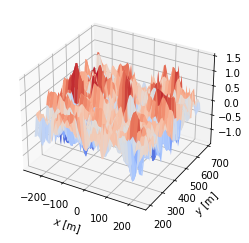

In [7]:
surf3d.plot_3d_surface()
plt.show()

In [8]:
spec3d = surf3d.define_SpectralAnalysis()
spec3d

In [9]:
spec3d.spectrum().shape

(1200, 66, 66)

In [10]:
spec3d.w[len(t)//2:]

array([-4.44089210e-16,  5.23598776e-03,  1.04719755e-02,  1.57079633e-02,
        2.09439510e-02,  2.61799388e-02,  3.14159265e-02,  3.66519143e-02,
        4.18879020e-02,  4.71238898e-02,  5.23598776e-02,  5.75958653e-02,
        6.28318531e-02,  6.80678408e-02,  7.33038286e-02,  7.85398163e-02,
        8.37758041e-02,  8.90117919e-02,  9.42477796e-02,  9.94837674e-02,
        1.04719755e-01,  1.09955743e-01,  1.15191731e-01,  1.20427718e-01,
        1.25663706e-01,  1.30899694e-01,  1.36135682e-01,  1.41371669e-01,
        1.46607657e-01,  1.51843645e-01,  1.57079633e-01,  1.62315620e-01,
        1.67551608e-01,  1.72787596e-01,  1.78023584e-01,  1.83259571e-01,
        1.88495559e-01,  1.93731547e-01,  1.98967535e-01,  2.04203522e-01,
        2.09439510e-01,  2.14675498e-01,  2.19911486e-01,  2.25147474e-01,
        2.30383461e-01,  2.35619449e-01,  2.40855437e-01,  2.46091425e-01,
        2.51327412e-01,  2.56563400e-01,  2.61799388e-01,  2.67035376e-01,
        2.72271363e-01,  

In [11]:
np.abs(spec3d.w)

array([3.14159265, 3.13635667, 3.13112068, ..., 3.12588469, 3.13112068,
       3.13635667])

In [12]:
freqs = np.arange(1, 2, 0.1)
kx_list = []
ky_list = []

for f in freqs:
    i = np.argmin(np.abs(spec3d.w[len(t)//2:] - f))
    # Finds the index of the closest value in spec3d.w to f 
        
    spec = spec3d.spectrum()
    spec_values = spec[len(t)//2 + i,:,:]
    # Gives the kx and ky values of corresponding to the frequencie[i]
    
    max_index = np.unravel_index(np.argmax(spec_values), spec_values.shape)
    # Finds the specific index of the maximum value in spec_values
    
    max_kx = spec3d.kx[max_index[0]]
    max_ky = spec3d.ky[max_index[1]]
    # Finds the value of kx and ky corresponding to the maximum spectral density 
        
    kx_list.append(max_kx)
    ky_list.append(max_ky)
    

In [13]:
def plot_triplets_vs_disp_surface(thresh_freq, max_freq, step_size, h, z, U, psi):
    freqs = np.arange(thresh_freq, max_freq, step_size)
    kx_list = []
    ky_list = []

    for f in freqs:
        i = np.argmin(np.abs(spec3d.w[len(t)//2:] - f))
        # Finds the index of the closest value in spec3d.w to f 
        
        spec = spec3d.spectrum()
        spec_values = spec[len(t)//2 + i,:,:]
        # Gives the kx and ky values of corresponding to the frequencie[i]
    
        max_index = np.unravel_index(np.argmax(spec_values), spec_values.shape)
        # Finds the specific index of the maximum value in spec_values
    
        max_kx = spec3d.kx[max_index[0]]
        max_ky = spec3d.ky[max_index[1]]
        # Finds the value of kx and ky corresponding to the maximum spectral density 
        
        kx_list.append(max_kx)
        ky_list.append(max_ky)
    
    fig = plt.figure(figsize=(7,7))
    axes = fig.add_subplot(111, projection='3d')
    plotting_interface.plot_disp_shell(axes, h, z, U, psi)
    
    kx = np.array(kx_list)
    ky = np.array(ky_list)    

    for j in range(0, len(freqs)):
        axes.scatter(kx_list[j], ky_list[j], freqs[j], color='red', s=40)
    
    plt.show()
    
    return kx, ky, freqs

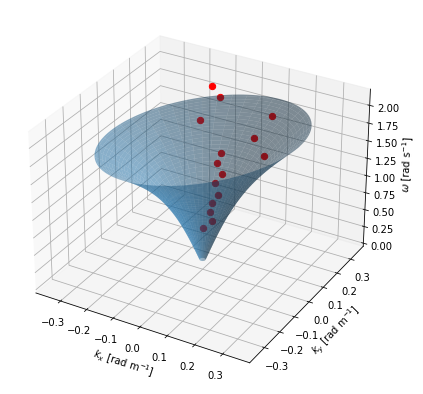

In [14]:
kx, ky, freqs = plot_triplets_vs_disp_surface(thresh_freq = 0.5 , max_freq = 2, step_size = 0.1, h = 10, z=z, U=U , psi = 0)

In [15]:
k_trip = np.sqrt( kx**2 + ky**2)
# Triplets k_i values

In [16]:
freqs

array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7,
       1.8, 1.9])

In [17]:
k_trip

array([0.02838309, 0.04013975, 0.05077321, 0.06346652, 0.07721035,
       0.10233669, 0.12693304, 0.14191545, 0.16695434, 0.21838385,
       0.23713048, 0.23949677, 0.31733259, 0.30910214, 0.33511283])

In [18]:
kx

array([-0.0126933 ,  0.0126933 ,  0.        ,  0.        ,  0.0126933 ,
       -0.0126933 ,  0.        , -0.02538661, -0.02538661,  0.12693304,
        0.06346652, -0.12693304,  0.08885313, -0.10154643, -0.13962634])

In [19]:
k

array([0.01  , 0.0105, 0.011 , 0.0115, 0.012 , 0.0125, 0.013 , 0.0135,
       0.014 , 0.0145, 0.015 , 0.0155, 0.016 , 0.0165, 0.017 , 0.0175,
       0.018 , 0.0185, 0.019 , 0.0195, 0.02  , 0.0205, 0.021 , 0.0215,
       0.022 , 0.0225, 0.023 , 0.0235, 0.024 , 0.0245, 0.025 , 0.0255,
       0.026 , 0.0265, 0.027 , 0.0275, 0.028 , 0.0285, 0.029 , 0.0295,
       0.03  , 0.0305, 0.031 , 0.0315, 0.032 , 0.0325, 0.033 , 0.0335,
       0.034 , 0.0345, 0.035 , 0.0355, 0.036 , 0.0365, 0.037 , 0.0375,
       0.038 , 0.0385, 0.039 , 0.0395, 0.04  , 0.0405, 0.041 , 0.0415,
       0.042 , 0.0425, 0.043 , 0.0435, 0.044 , 0.0445, 0.045 , 0.0455,
       0.046 , 0.0465, 0.047 , 0.0475, 0.048 , 0.0485, 0.049 , 0.0495,
       0.05  , 0.0505, 0.051 , 0.0515, 0.052 , 0.0525, 0.053 , 0.0535,
       0.054 , 0.0545, 0.055 , 0.0555, 0.056 , 0.0565, 0.057 , 0.0575,
       0.058 , 0.0585, 0.059 , 0.0595, 0.06  , 0.0605, 0.061 , 0.0615,
       0.062 , 0.0625, 0.063 , 0.0635, 0.064 , 0.0645, 0.065 , 0.0655,
      

In [20]:
def w0(x):
    return np.sqrt(9.81 * x)

In [21]:
w0(k)

array([0.3132092 , 0.32094392, 0.32849658, 0.33587944, 0.34310348,
       0.35017853, 0.35711343, 0.3639162 , 0.37059412, 0.37715381,
       0.38360136, 0.3899423 , 0.39618178, 0.4023245 , 0.40837483,
       0.41433682, 0.42021423, 0.42601056, 0.43172908, 0.43737284,
       0.44294469, 0.44844732, 0.45388324, 0.45925483, 0.46456431,
       0.46981379, 0.47500526, 0.4801406 , 0.4852216 , 0.49024994,
       0.49522722, 0.50015498, 0.50503465, 0.50986763, 0.51465522,
       0.51939869, 0.52409923, 0.52875798, 0.53337604, 0.53795446,
       0.54249424, 0.54699634, 0.55146169, 0.55589118, 0.56028564,
       0.56464591, 0.56897276, 0.57326695, 0.57752922, 0.58176026,
       0.58596075, 0.59013134, 0.59427266, 0.59838533, 0.60246992,
       0.606527  , 0.61055712, 0.61456082, 0.6185386 , 0.62249096,
       0.62641839, 0.63032135, 0.63420028, 0.63805564, 0.64188784,
       0.6456973 , 0.64948441, 0.65324957, 0.65699315, 0.66071552,
       0.66441704, 0.66809805, 0.67175889, 0.67539988, 0.67902

Text(0.5, 1.0, 'k against $\\omega_{0}$')

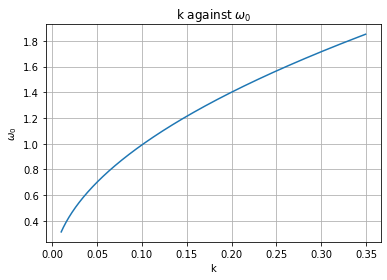

In [22]:
plt.plot(k,w0(k))

plt.xlabel("k")
plt.ylabel("$\omega_{0}$")
plt.grid(True)
plt.title("k against $\omega_{0}$")

In [23]:
# error function 
def error_function(U, k_trip, wi, w0):
    residuals = wi - w0 - k_trip*U
    return np.sum(residuals**2)

In [24]:
initial_U_guess = np.zeros(len(k_trip))

In [25]:
len(initial_U_guess)

15

In [26]:
len(k_trip)

15

In [27]:
result = minimize(error_function, initial_U_guess, args=(k_trip, freqs ,w0(k_trip)))

optimized_U = result.x
optimized_U

array([-0.97498328, -0.6853768 , -0.11361439,  0.17227115,  0.38462482,
       -0.01893918, -0.12520383,  0.14155546,  0.12114918, -0.29157779,
       -0.10630912,  0.28060519, -0.20286749,  0.18975156,  0.25920837])

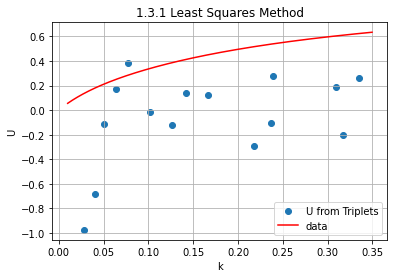

In [28]:
plt.scatter(k_trip, optimized_U, label = "U from Triplets")
plt.plot(k,Uk[:,0], label = 'data', color = 'red')

plt.xlabel("k")
plt.ylabel("U")
plt.grid(True)
plt.title("1.3.1 Least Squares Method")
plt.legend(loc = "lower right")

In [29]:
sorted(np.abs(optimized_U))

[0.018939184615243354,
 0.10630911757890109,
 0.11361439390060805,
 0.12114917675542405,
 0.12520383083848152,
 0.1415554606528148,
 0.17227115472065482,
 0.18975155542423938,
 0.20286748726426204,
 0.25920837198158314,
 0.28060519053981003,
 0.2915777870593781,
 0.3846248224043907,
 0.685376797536805,
 0.9749832849456788]

In [30]:
freqs - w0(k_trip) - k_trip*optimized_U

array([ 6.86064382e-07, -8.61793923e-07,  1.70286782e-05,  1.23410360e-05,
       -3.60262567e-06, -2.13501612e-05,  1.33921190e-06, -1.55887771e-07,
       -6.21161094e-07,  5.06114850e-07,  4.22067925e-06,  3.43730338e-08,
       -2.38289495e-06, -3.73034653e-07,  1.40124268e-06])

In [31]:
initial_U_guess

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [32]:
spec3d.spectrum().shape

(1200, 66, 66)

In [33]:
spec3d.estimate_Ueff_psi(h=10, Umax=2)

C:\Users\josep\Documents\Anaconda\pkgs\wave_tools\SpectralAnalysis.py:702: RuntimeWarning: invalid value encountered in divide
  w_peaks = (np.sum(input_spec**pow * ww**pow2, axis=0)/np.sum(input_spec**pow, axis=0))**(1./pow2)


(array([0.80110613, 0.80634211, 0.8115781 , 0.81681409, 0.82205008,
        0.82728607, 0.83252205, 0.83775804, 0.84299403, 0.84823002,
        0.853466  , 0.85870199, 0.86393798, 0.86917397, 0.87440996,
        0.87964594, 0.88488193, 0.89011792, 0.89535391, 0.90058989,
        0.90582588, 0.91106187, 0.91629786, 0.92153385, 0.92676983,
        0.93200582, 0.93724181, 0.9424778 , 0.94771378, 0.95294977,
        0.95818576, 0.96342175, 0.96865773, 0.97389372, 0.97912971,
        0.9843657 , 0.98960169, 0.99483767, 1.00007366, 1.00530965,
        1.01054564, 1.01578162, 1.02101761, 1.0262536 , 1.03148959,
        1.03672558, 1.04196156, 1.04719755, 1.05243354, 1.05766953,
        1.06290551, 1.0681415 , 1.07337749, 1.07861348, 1.08384947,
        1.08908545, 1.09432144, 1.09955743, 1.10479342, 1.1100294 ,
        1.11526539, 1.12050138, 1.12573737, 1.13097336, 1.13620934,
        1.14144533, 1.14668132, 1.15191731, 1.15715329, 1.16238928,
        1.16762527, 1.17286126, 1.17809725, 1.18

In [34]:
r = np.sqrt( (kx)**2 + (ky)**2 )
theta = np.arctan2(ky,kx)

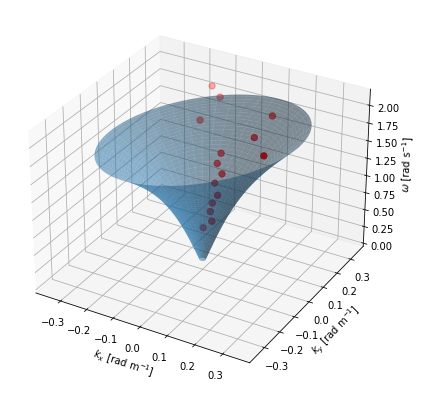

In [35]:
fig = plt.figure(figsize=(7,7))
axes = fig.add_subplot(111, projection='3d')

plotting_interface.plot_disp_shell(axes, h=10, z = z, U = U, psi = 0)
axes.scatter(r*np.cos(theta), r*np.sin(theta), freqs, color='red', s=40)

In [36]:
def plot_disp_shell(axes, h, z, U, psi, label='', plot_type='surf', linestyles='line', put_clabel=True):
    g = 9.81
    alpha = 0.5 # value that defines opacity in plot
    dk = 0.005
    k = np.arange(0.01, 0.35, dk)
    dtheta=0.05
    theta=np.arange(0, 2*np.pi+dtheta, dtheta)
    kk, th = np.meshgrid(k, theta, indexing='ij')
    U_eff = 2*kk*np.sum(U*np.exp(np.outer(2*kk,z)), axis=1).reshape(kk.shape)*np.abs(z[1]-z[0])
    ww = kk*U_eff*np.cos(theta-psi) + np.sqrt(kk*g*np.tanh(kk*h))
    kx = kk*np.cos(th)
    ky = kk*np.sin(th)
    if plot_type=='surf':
        axes.plot_surface(kx, ky, ww, alpha=alpha, label=label)
        axes.set_xlabel(r'$k_x~[\mathrm{rad~m}^{-1}]$')
        axes.set_ylabel(r'$k_y~[\mathrm{rad~m}^{-1}]$')
        axes.set_zlabel(r'$\omega~[\mathrm{rad~s}^{-1}]$')
    elif plot_type=='contour':
        levels = [0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8]
        c = plt.contour(kx, ky, ww, levels=levels, linestyles=linestyles)#, label=label)
        if put_clabel:
            plt.clabel(c)
        plt.xlabel(r'$k_x~[\mathrm{rad~m}^{-1}]$') 
        plt.ylabel(r'$k_y~[\mathrm{rad~m}^{-1}]$')
        plt.axis('equal')
        
    return kx, ky, ww

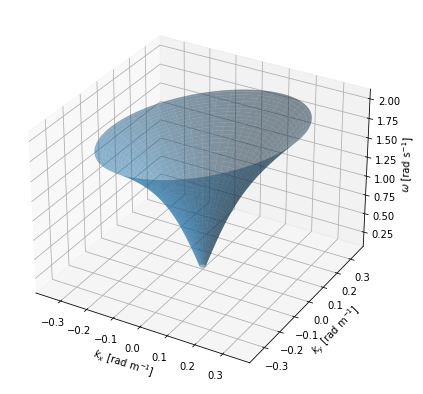

In [37]:
fig = plt.figure(figsize=(7,7))
axes = fig.add_subplot(111, projection='3d')
disp_kx, disp_ky, disp_ww = plot_disp_shell(axes, h=10, z = z, U = U, psi = 0)

In [38]:
def plot_disp_relation_and_points_at_theta(spec_theta, thresh_freq, max_freq, step_size, h, z, U, psi):
    '''
    This function finds the relationship between triplets found from spectrum from FFT 
    and the dispersion relation at specific theta. 
    It plots it in the Radial vs Omega Space. 
    '''
    
    # (1) TRIPLET POINTS
    
    freqs = np.arange(thresh_freq, max_freq, step_size)
    kx_list = []
    ky_list = []

    # This gets the triplets points 
    # Triplets are (max_kx, mak_ky, freqs)
    for f in freqs:
        i = np.argmin(np.abs(spec3d.w[len(t)//2:]-f))
        spec = spec3d.spectrum()
        spec_values = spec[len(t)//2 + i,:,:]
        # Gives the spectrum values represented by colour
    
        max_index = np.unravel_index(np.argmax(spec_values), spec_values.shape)
        # Finds the specific index of the maximum value in spec_values
    
        max_kx = spec3d.kx[max_index[0]]
        max_ky = spec3d.ky[max_index[1]]
        # Finds the value of kx and ky corresponding to the maximum spectral density 
        
        kx_list.append(max_kx)
        ky_list.append(max_ky)
        
    kx = np.array(kx_list)
    ky = np.array(ky_list)
    
    # transform Triplets to polar coordinates
    r = np.sqrt( (kx)**2 + (ky)**2 )
    theta = np.arctan2(ky,kx)
    
    # (2) DISPERSION SURFACE
    axes = fig.add_subplot(111, projection='3d')
    
    
    # Convert Dispersion Surface to Polars by first removing mesh grid format
    matrix_disp_r = np.sqrt( (disp_kx)**2 + (disp_ky)**2 )
    disp_r = matrix_disp_r[:,0]
    
    matrix_disp_theta = np.arctan2(disp_ky,disp_kx)
    disp_theta = matrix_disp_theta[0]
    
    nearest_index = np.argmin(np.abs(disp_theta - spec_theta))
    disp_ww_for_theta = disp_ww[:, nearest_index]
    
    plt.scatter(r, freqs, color = 'red', zorder=1, label = 'Triplets', s = 40)
    plt.plot(disp_r,disp_ww_for_theta, color='grey',zorder=0, label = 'Dispersion Relation at $\Theta$')
    plt.grid(True)
    plt.xlabel('Radial Distance (r)')
    plt.ylabel('$\omega$')
    plt.title("Dispersion Relation vs Triplets in Radial-Frequency Space")
    plt.legend()
    
    return r, theta, freqs, kx, ky, disp_r, disp_ww_for_theta

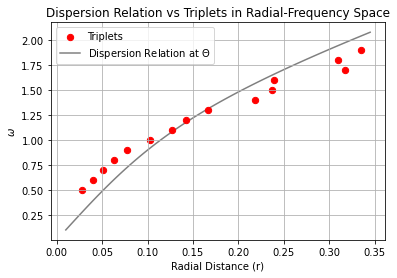

In [39]:
r, theta, freqs, kx, ky, disp_r,disp_ww_for_theta = plot_disp_relation_and_points_at_theta(0, thresh_freq = 0.5 , 
                                                  max_freq = 2, step_size = 0.1, h=10, 
                                                  z = z, U = U , psi = 0)

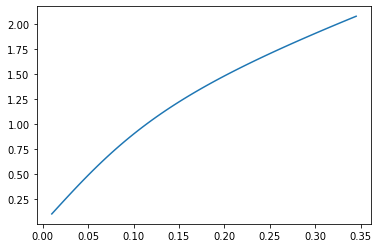

In [40]:
plt.plot(disp_r,disp_ww_for_theta)

# Try with actual values

In [41]:
DWL_kx = np.arange(0.01, 0.35, 0.0001)
DWL_ky = np.arange(0.01, 0.35, 0.0001)
# DWL = deep water limit

DWL_omega = np.sqrt( 9.81 * np.sqrt( (DWL_kx)**2  + (DWL_ky)**2 ) )
# DWL formula

In [42]:
# Find the value of DWL dispersion relation omega where the r values are closest to the DWL_kx values
near_indice = [np.argmin(np.abs(DWL_kx - rx)) for rx in r]

# Corresponding DWL_kx values
DWL_kx_values = DWL_kx[near_indice]
DWL_omega_values = DWL_omega[near_indice]

DWL_kx_values

array([0.0284, 0.0401, 0.0508, 0.0635, 0.0772, 0.1023, 0.1269, 0.1419,
       0.167 , 0.2184, 0.2371, 0.2395, 0.3173, 0.3091, 0.3351])

In [43]:
near_indice

[184,
 301,
 408,
 535,
 672,
 923,
 1169,
 1319,
 1570,
 2084,
 2271,
 2295,
 3073,
 2991,
 3251]

In [44]:
r

array([0.02838309, 0.04013975, 0.05077321, 0.06346652, 0.07721035,
       0.10233669, 0.12693304, 0.14191545, 0.16695434, 0.21838385,
       0.23713048, 0.23949677, 0.31733259, 0.30910214, 0.33511283])

In [45]:
disp_r

array([0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 , 0.045, 0.05 ,
       0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085, 0.09 , 0.095,
       0.1  , 0.105, 0.11 , 0.115, 0.12 , 0.125, 0.13 , 0.135, 0.14 ,
       0.145, 0.15 , 0.155, 0.16 , 0.165, 0.17 , 0.175, 0.18 , 0.185,
       0.19 , 0.195, 0.2  , 0.205, 0.21 , 0.215, 0.22 , 0.225, 0.23 ,
       0.235, 0.24 , 0.245, 0.25 , 0.255, 0.26 , 0.265, 0.27 , 0.275,
       0.28 , 0.285, 0.29 , 0.295, 0.3  , 0.305, 0.31 , 0.315, 0.32 ,
       0.325, 0.33 , 0.335, 0.34 , 0.345])

In [46]:
yoke = np.array([disp_ww_for_theta[4], disp_ww_for_theta[6], disp_ww_for_theta[9], disp_ww_for_theta[11],
                disp_ww_for_theta[13], disp_ww_for_theta[18], disp_ww_for_theta[23], disp_ww_for_theta[26],
                disp_ww_for_theta[31], disp_ww_for_theta[41], disp_ww_for_theta[45], disp_ww_for_theta[46],
                disp_ww_for_theta[62], disp_ww_for_theta[60], disp_ww_for_theta[65] ])

In [47]:
len(yoke)

15

In [48]:
# Objective function to be minimize
def objective(U,k_trip, DWL_omega_values, freqs):
    return DWL_omega_values - yoke + r*U*np.cos(0)

# Initial guess for U
initial_U = np.zeros(len(r))

# Perform the least squares fit using least_squares
result = least_squares(objective, initial_U, args=(k_trip, DWL_omega_values, disp_ww_for_theta))

# Optimized U values
optimized_U = result.x

# Print the optimized U values
print("Optimized U values:", optimized_U)

Optimized U values: [-11.6420229   -8.77646463  -6.04287736  -5.00260759  -4.2638314
  -2.84657816  -2.01426066  -1.68332811  -1.29484771  -0.85949037
  -0.72270382  -0.66319627  -0.35004572  -0.39544462  -0.3349357 ]


In [49]:
disp_ww_for_theta

array([0.09945258, 0.14925219, 0.19890704, 0.24828436, 0.29726204,
       0.34572921, 0.3935867 , 0.44074734, 0.48713606, 0.5326898 ,
       0.57735722, 0.62109827, 0.66388353, 0.70569348, 0.74651766,
       0.78635382, 0.8252069 , 0.86308821, 0.90001443, 0.93600679,
       0.97109023, 1.00529266, 1.03864424, 1.07117679, 1.10292323,
       1.13391711, 1.16419221, 1.19378216, 1.2227202 , 1.2510389 ,
       1.27877001, 1.30594427, 1.33259134, 1.35873971, 1.38441663,
       1.40964808, 1.43445879, 1.45887221, 1.48291052, 1.50659472,
       1.52994456, 1.5529787 , 1.57571463, 1.59816883, 1.62035674,
       1.64229285, 1.66399073, 1.6854631 , 1.70672185, 1.72777813,
       1.74864236, 1.76932427, 1.78983298, 1.81017702, 1.83036435,
       1.85040243, 1.87029824, 1.8900583 , 1.90968872, 1.92919523,
       1.94858319, 1.96785761, 1.98702321, 2.00608442, 2.02504537,
       2.04390997, 2.06268188, 2.08136456])

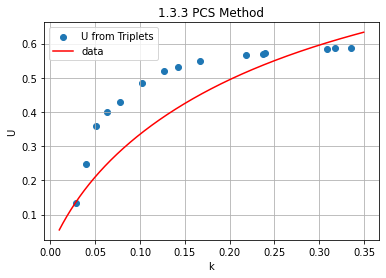

In [50]:
plt.scatter(k_trip, 0.04*optimized_U + 0.6, label = "U from Triplets")
plt.plot(k,Uk[:,0], label = "data", color = "red")

plt.xlabel("k")
plt.ylabel("U")
plt.title("1.3.3 PCS Method")
plt.grid(True)
plt.legend()

# Test Method

In [51]:
f = h5py.File('C:\\Users\josep\Downloads\data_psi_zero.hdf5', 'r')

In [52]:
x = f.get('x')
y = f.get('y')
z = f.get('z')
t = f.get('t')
k = f.get('k')
U = f.get('U')
Uk = f.get('Uk')

In [53]:
x = np.array(x)
y = np.array(y)
z = np.array(z)
t = np.array(t)
k = np.array(k)
U = np.array(U)
Uk = np.array(Uk)

## Find Correct Triplet $\omega$

In [54]:
kx_0 = np.arange(0.01, 0.35, 0.0005)
ky_0 = np.arange(0.01, 0.35, 0.0005)
# DWL = deep water limit

w_0 = np.sqrt( 9.81 * np.sqrt( (kx_0)**2  + (ky_0)**2 ) )
# DWL formula

In [55]:
velocity = Uk[:,0]

In [56]:
k*velocity

array([0.00054946, 0.00060328, 0.00065939, 0.00071776, 0.00077836,
       0.00084117, 0.00090616, 0.00097331, 0.00104259, 0.00111399,
       0.00118747, 0.00126301, 0.0013406 , 0.0014202 , 0.0015018 ,
       0.00158538, 0.00167091, 0.00175838, 0.00184776, 0.00193904,
       0.0020322 , 0.00212721, 0.00222406, 0.00232274, 0.00242321,
       0.00252547, 0.0026295 , 0.00273528, 0.0028428 , 0.00295203,
       0.00306296, 0.00317559, 0.00328988, 0.00340583, 0.00352342,
       0.00364264, 0.00376347, 0.0038859 , 0.00400991, 0.0041355 ,
       0.00426264, 0.00439132, 0.00452154, 0.00465327, 0.00478652,
       0.00492125, 0.00505747, 0.00519515, 0.0053343 , 0.00547489,
       0.00561692, 0.00576037, 0.00590523, 0.0060515 , 0.00619915,
       0.00634819, 0.0064986 , 0.00665037, 0.0068035 , 0.00695796,
       0.00711375, 0.00727087, 0.0074293 , 0.00758903, 0.00775006,
       0.00791237, 0.00807596, 0.00824081, 0.00840692, 0.00857429,
       0.0087429 , 0.00891274, 0.00908381, 0.00925609, 0.00942

In [57]:
correct_w_trips = w_0 + k*velocity
correct_w_trips

array([0.37302007, 0.38227208, 0.39130985, 0.40014798, 0.40879946,
       0.41727596, 0.42558799, 0.43374504, 0.44175576, 0.44962799,
       0.45736893, 0.46498517, 0.47248278, 0.47986735, 0.48714405,
       0.49431767, 0.50139267, 0.50837317, 0.51526306, 0.52206594,
       0.52878518, 0.53542396, 0.54198525, 0.54847185, 0.5548864 ,
       0.56123138, 0.56750914, 0.5737219 , 0.57987177, 0.58596074,
       0.5919907 , 0.59796344, 0.60388068, 0.60974404, 0.61555508,
       0.62131526, 0.627026  , 0.63268865, 0.63830449, 0.64387477,
       0.64940065, 0.65488327, 0.66032371, 0.66572302, 0.67108219,
       0.67640218, 0.68168392, 0.68692829, 0.69213616, 0.69730833,
       0.70244561, 0.70754876, 0.71261851, 0.71765558, 0.72266066,
       0.72763441, 0.73257748, 0.73749047, 0.742374  , 0.74722864,
       0.75205496, 0.7568535 , 0.76162479, 0.76636934, 0.77108764,
       0.77578019, 0.78044744, 0.78508985, 0.78970785, 0.79430189,
       0.79887237, 0.80341969, 0.80794425, 0.81244644, 0.81692

In [58]:
kx_0 = np.arange(0.01, 0.35, 0.0005)
ky_0 = np.arange(0.01, 0.35, 0.0005)
# DWL = deep water limit

w_0 = np.sqrt( 9.81 * np.sqrt( (kx_0)**2  + (ky_0)**2 ) )
# DWL formula

## Add Noise

In [59]:
# add noise 
noise_level = 0.1
noisy_w = correct_w_trips + np.random.uniform(-noise_level, noise_level, len(correct_w_trips))

In [60]:
noisy_w

array([0.41642962, 0.41572087, 0.36628898, 0.35156187, 0.36048589,
       0.5156465 , 0.4642256 , 0.41395083, 0.44149571, 0.54130484,
       0.44128394, 0.48801678, 0.50275184, 0.39194006, 0.40789978,
       0.4216228 , 0.55328909, 0.55128158, 0.51029348, 0.45773273,
       0.46990436, 0.5146163 , 0.61585285, 0.58961182, 0.45633013,
       0.59805773, 0.59636359, 0.47480002, 0.5201042 , 0.63614038,
       0.55947338, 0.67619884, 0.50476886, 0.70617364, 0.55953555,
       0.67514211, 0.67075632, 0.55842844, 0.64624797, 0.56645436,
       0.63521768, 0.72840123, 0.64354481, 0.71718334, 0.58640268,
       0.74013723, 0.66535624, 0.78223847, 0.73783519, 0.78193219,
       0.64841785, 0.72009712, 0.71733816, 0.73804092, 0.74522601,
       0.77071245, 0.75291379, 0.65525642, 0.69189991, 0.69090459,
       0.79361039, 0.78757422, 0.791354  , 0.80623974, 0.71347055,
       0.77233176, 0.78874034, 0.80929777, 0.7137731 , 0.83482437,
       0.85136567, 0.83805968, 0.81814156, 0.76744375, 0.75887

In [61]:
kx_0.shape

(680,)

Text(0.5, 0, 'k')

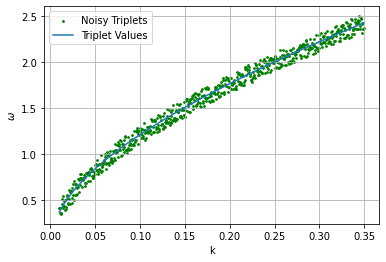

In [62]:
plt.scatter(k, noisy_w , color = 'green', label = 'Noisy Triplets', s = 3)

plt.plot(k, correct_w_trips, label = 'Triplet Values')

plt.grid(True)
plt.legend()
plt.ylabel("$\omega$")
plt.xlabel("k")

## Try method on this data to find U from Noisy Triplets 

In [219]:
def obj(U, w_i, w_0, k):
    return (w_i - w_0 - k*U)**2

# Initial guess for U
initial_U = np.zeros(len(k))

# Perform the least squares fit using least_squares
result = least_squares(obj, initial_U, args=( noisy_w, w_0, k))

# Optimized U values
optimized_U = result.x

optimized_U

array([ 4.26640905e+00,  3.14571004e+00, -2.14706075e+00, -4.04337691e+00,
       -3.84856915e+00,  7.75211609e+00,  2.95392806e+00, -1.35147744e+00,
        5.41497284e-02,  6.25446921e+00, -9.62634320e-01,  1.52053968e+00,
        1.91838589e+00, -5.12656370e+00, -4.46889581e+00, -3.96888913e+00,
        2.90086010e+00,  2.35083621e+00, -1.59177762e-01, -3.12470888e+00,
       -2.77429382e+00, -8.84039739e-01,  3.54616201e+00,  1.97003691e+00,
       -4.28494305e+00,  1.70374756e+00,  1.33166009e+00, -4.01531348e+00,
       -2.31844516e+00,  2.11897083e+00, -1.14627003e+00,  3.13030283e+00,
       -3.61747969e+00,  3.69906493e+00, -1.90106812e+00,  2.04507327e+00,
        1.65764408e+00, -2.42055694e+00,  3.99785312e-01, -2.43639334e+00,
       -3.20633603e-01,  2.50662301e+00, -3.83587919e-01,  1.74471244e+00,
       -2.45094607e+00,  2.07222088e+00, -3.31302038e-01,  2.94904555e+00,
        1.46988336e+00,  2.56618587e+00, -1.35427407e+00,  5.01402260e-01,
        2.86324476e-01,  

Text(0.5, 0, 'k')

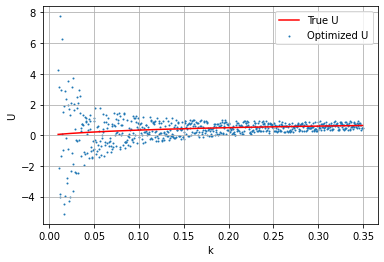

In [220]:
plt.plot(k, Uk[:,0], label = 'True U ', color = 'red')
plt.scatter(k, np.array(optimized_U), s =1, label = "Optimized U")

plt.grid(True)
plt.legend()
plt.ylabel("U")
plt.xlabel("k")

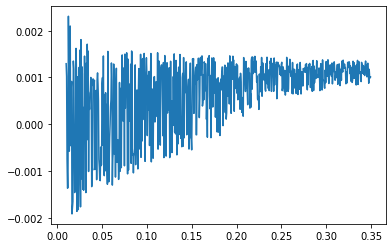

In [221]:
plt.plot(k, noisy_w - w_0 - k*optimized_U)

Text(0.5, 0, 'k')

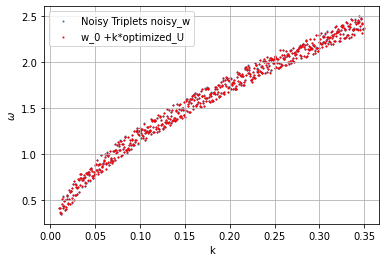

In [222]:
plt.scatter(k, noisy_w, s = 1, label="Noisy Triplets noisy_w")
plt.scatter(k, w_0+k*optimized_U, label='w_0 +k*optimized_U', color = 'red', s = 1)

plt.grid(True)
plt.legend()
plt.ylabel("$\omega$")
plt.xlabel("k")

Can see they match

# Try Fitting Triplets

Text(0.5, 0, 'k')

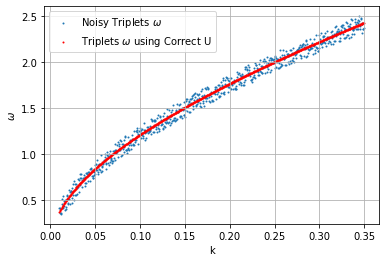

In [223]:
#plt.scatter(k, correct_w_trips, s = 1, label="correct Triplets w")
plt.scatter(k, noisy_w, s = 1, label="Noisy Triplets $\omega$")
plt.scatter(k, w_0+k*Uk[:,0], label='Triplets $\omega$ using Correct U', color = 'red', s = 1)

plt.grid(True)
plt.legend()
plt.ylabel("$\omega$")
plt.xlabel("k")

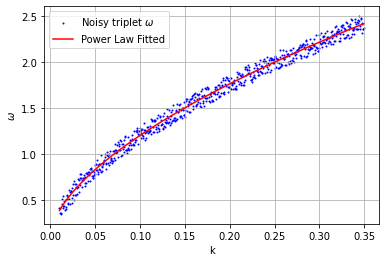

In [224]:
# Use fitting function
def power_law_function(x, a, b, c):
    return a*x**b+c

# Fit the curve
param, covariance = curve_fit(power_law_function, k, noisy_w)
a, b, c = param

# Fitted curve points
k_fit = np.linspace(min(k), max(k), 680)
y_fit = power_law_function(k_fit, a, b, c)

# Plot data and fitted curve
plt.scatter(k, noisy_w, label='Noisy triplet $\omega$ ', s=1, color='blue')
plt.plot(k_fit, y_fit, label='Power Law Fitted', color='red')

plt.ylabel('$\omega$')
plt.xlabel('k')
plt.grid(True)
plt.legend()

In [225]:
def obj(U, w_i, w_0, k):
    return (w_i - w_0 - k*U)**2

# Initial guess for U
initial_U = np.zeros(len(k))

# Perform the least squares fit using least_squares
result = least_squares(obj, initial_U, args=( y_fit, w_0, k))

# Optimized U values
optimized_U = result.x

# Print the optimized U values
print("Optimized U values:", optimized_U)

Optimized U values: [ 1.51720547e+00  1.34908450e+00  1.20164747e+00  1.07179289e+00
  9.56980934e-01  8.55114626e-01  7.64449547e-01  6.83524529e-01
  6.11107845e-01  5.46155044e-01  4.87775630e-01  4.35206494e-01
  3.87790591e-01  3.44959679e-01  3.06220279e-01  2.71142167e-01
  2.39348887e-01  2.10509895e-01  1.84334018e-01  1.60563969e-01
  1.38971748e-01  1.19354746e-01  1.01532451e-01  8.53436350e-02
  7.06439574e-02  5.73039034e-02  4.52070133e-02  3.42483533e-02
  2.43331901e-02  1.53758405e-02  7.29866906e-03  3.12125239e-05
 -6.49060142e-03 -1.23250693e-02 -1.75253911e-02 -2.21401347e-02
 -2.62137127e-02 -2.97867911e-02 -3.28966528e-02 -3.55775210e-02
 -3.78608467e-02 -3.97755659e-02 -4.13483299e-02 -4.26037109e-02
 -4.35643874e-02 -4.42513098e-02 -4.46838507e-02 -4.48799394e-02
 -4.48561837e-02 -4.46279805e-02 -4.42096150e-02 -4.36143518e-02
 -4.28545164e-02 -4.19415700e-02 -4.08861778e-02 -3.96982705e-02
 -3.83871008e-02 -3.69612953e-02 -3.54289011e-02 -3.37974294e-02
 -3.2

Text(0.5, 0, 'k')

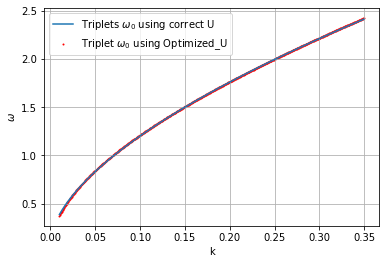

In [226]:
#plt.scatter(k, correct_w_trips, s = 1, label="correct Triplets w")
plt.plot(k, w_0+k*optimized_U, label="Triplets $\omega_{0}$ using correct U ")
plt.scatter(k, w_0+k*Uk[:,0], label='Triplet $\omega_{0}$ using Optimized_U', color = 'red', s = 1)

plt.grid(True)
plt.legend()
plt.ylabel("$\omega$")
plt.xlabel("k")

In [227]:
correct_w_trips

array([0.37302007, 0.38227208, 0.39130985, 0.40014798, 0.40879946,
       0.41727596, 0.42558799, 0.43374504, 0.44175576, 0.44962799,
       0.45736893, 0.46498517, 0.47248278, 0.47986735, 0.48714405,
       0.49431767, 0.50139267, 0.50837317, 0.51526306, 0.52206594,
       0.52878518, 0.53542396, 0.54198525, 0.54847185, 0.5548864 ,
       0.56123138, 0.56750914, 0.5737219 , 0.57987177, 0.58596074,
       0.5919907 , 0.59796344, 0.60388068, 0.60974404, 0.61555508,
       0.62131526, 0.627026  , 0.63268865, 0.63830449, 0.64387477,
       0.64940065, 0.65488327, 0.66032371, 0.66572302, 0.67108219,
       0.67640218, 0.68168392, 0.68692829, 0.69213616, 0.69730833,
       0.70244561, 0.70754876, 0.71261851, 0.71765558, 0.72266066,
       0.72763441, 0.73257748, 0.73749047, 0.742374  , 0.74722864,
       0.75205496, 0.7568535 , 0.76162479, 0.76636934, 0.77108764,
       0.77578019, 0.78044744, 0.78508985, 0.78970785, 0.79430189,
       0.79887237, 0.80341969, 0.80794425, 0.81244644, 0.81692

In [228]:
w_0[0]+k[0]*optimized_U[0]

0.38764265824168764

In [229]:
w_0[0]+k[0]*Uk[:,0][0]

0.3730200650354485

Text(0.5, 0, 'k')

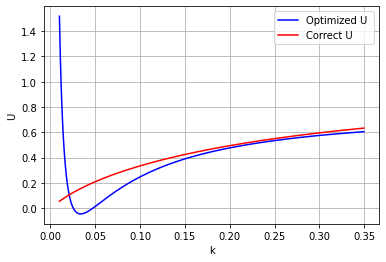

In [230]:
plt.plot(k, optimized_U, label='Optimized U ', color='blue')
plt.plot(k, Uk[:,0], label = 'Correct U', color='red')

plt.grid(True)
plt.legend()
plt.ylabel("U")
plt.xlabel("k")

#plt.xlim(0.1, 0.35)
#plt.ylim(0,1)

In [75]:
correct_w_trips

array([0.37302007, 0.38227208, 0.39130985, 0.40014798, 0.40879946,
       0.41727596, 0.42558799, 0.43374504, 0.44175576, 0.44962799,
       0.45736893, 0.46498517, 0.47248278, 0.47986735, 0.48714405,
       0.49431767, 0.50139267, 0.50837317, 0.51526306, 0.52206594,
       0.52878518, 0.53542396, 0.54198525, 0.54847185, 0.5548864 ,
       0.56123138, 0.56750914, 0.5737219 , 0.57987177, 0.58596074,
       0.5919907 , 0.59796344, 0.60388068, 0.60974404, 0.61555508,
       0.62131526, 0.627026  , 0.63268865, 0.63830449, 0.64387477,
       0.64940065, 0.65488327, 0.66032371, 0.66572302, 0.67108219,
       0.67640218, 0.68168392, 0.68692829, 0.69213616, 0.69730833,
       0.70244561, 0.70754876, 0.71261851, 0.71765558, 0.72266066,
       0.72763441, 0.73257748, 0.73749047, 0.742374  , 0.74722864,
       0.75205496, 0.7568535 , 0.76162479, 0.76636934, 0.77108764,
       0.77578019, 0.78044744, 0.78508985, 0.78970785, 0.79430189,
       0.79887237, 0.80341969, 0.80794425, 0.81244644, 0.81692

In [76]:
y_fit

array([0.38813176, 0.39629084, 0.40429472, 0.41215322, 0.41987512,
       0.42746836, 0.4349401 , 0.44229685, 0.44954454, 0.45668861,
       0.46373404, 0.4706854 , 0.47754693, 0.48432255, 0.49101589,
       0.49763032, 0.50416899, 0.51063483, 0.51703061, 0.52335888,
       0.52962207, 0.53582244, 0.54196214, 0.54804319, 0.55406748,
       0.56003683, 0.56595294, 0.57181742, 0.57763181, 0.58339757,
       0.58911609, 0.59478868, 0.6004166 , 0.60600106, 0.61154321,
       0.61704412, 0.62250487, 0.62792644, 0.63330981, 0.63865588,
       0.64396555, 0.64923966, 0.65447903, 0.65968444, 0.66485664,
       0.66999637, 0.67510432, 0.68018117, 0.68522755, 0.69024411,
       0.69523145, 0.70019014, 0.70512076, 0.71002384, 0.71489993,
       0.71974952, 0.72457311, 0.72937119, 0.73414421, 0.73889262,
       0.74361687, 0.74831737, 0.75299453, 0.75764875, 0.76228043,
       0.76688992, 0.77147761, 0.77604384, 0.78058896, 0.78511331,
       0.78961721, 0.79410098, 0.79856493, 0.80300937, 0.80743

In [77]:
w_0[0]+k[0]*optimized_U[0]

0.3881317623883137

In [78]:
w_0[0]

0.3724706034961694

In [79]:
w_0[0]+k[0]*Uk[:,0][0]

0.3730200650354485

Text(0.5, 0, 'k')

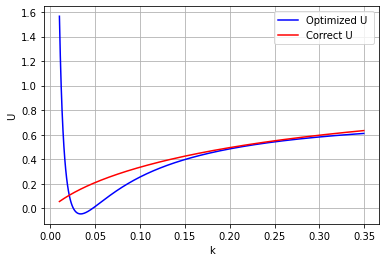

In [80]:
plt.plot(k, optimized_U, label='Optimized U ', color='blue')
plt.plot(k, Uk[:,0], label = 'Correct U', color='red')

plt.grid(True)
plt.legend()
plt.ylabel("U")
plt.xlabel("k")

#plt.xlim(0.1, 0.35)
#plt.ylim(0,1)

In [81]:
w_0[300]+k[300]*(optimized_U[300])

1.5567740714429101

In [82]:
w_0[300]+k[300]*Uk[:,0][300]

1.5603193640530733

In [83]:
correct_w_trips[0]

0.3730200650354485

In [84]:
y_fit[0]

0.3881317624028686

In [85]:
w_0[0]

0.3724706034961694

In [86]:
k[0]

0.01

In [87]:
y_fit - w_0 - k*optimized_U

array([ 1.45548920e-11, -3.49360783e-11, -7.37446319e-11,  2.46599928e-11,
       -1.19236895e-11,  6.14522808e-11,  2.78271503e-11,  6.54587495e-13,
       -2.10625545e-11, -3.81592483e-11,  7.00064312e-12, -9.15811437e-12,
        1.29780388e-12, -1.10461258e-11, -2.34082372e-12,  4.53233805e-12,
       -4.45648119e-12,  1.20554174e-12,  4.39661328e-14, -8.42220391e-13,
       -1.49043842e-12, -1.93347725e-12,  8.22023439e-13,  2.23444310e-13,
       -2.01682638e-13, -4.76937066e-13,  4.83517306e-14,  1.03737982e-13,
       -5.92243268e-14, -7.29857797e-15, -2.70530126e-15,  3.02814279e-20,
        1.05747659e-15,  7.29993323e-16, -3.31847180e-14, -8.51078106e-14,
        4.18335071e-14, -1.05564429e-14,  1.67017442e-13,  3.73629513e-13,
        4.46483128e-14,  2.62504862e-13, -1.12004373e-13,  1.15332006e-13,
        3.53562232e-13, -5.20128645e-14, -4.67128072e-13, -2.26524528e-13,
        1.57857668e-14,  2.56323391e-13, -1.55347740e-13,  8.16783707e-14,
       -3.15765860e-13, -

In [88]:
optimized_U[0]

1.5661158892144333

## Trying to find mistake in my findings of Triplets

In [89]:
k_trip

array([0.02838309, 0.04013975, 0.05077321, 0.06346652, 0.07721035,
       0.10233669, 0.12693304, 0.14191545, 0.16695434, 0.21838385,
       0.23713048, 0.23949677, 0.31733259, 0.30910214, 0.33511283])

In [90]:
freqs

array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7,
       1.8, 1.9])

In [91]:
correct_w_trips

array([0.37302007, 0.38227208, 0.39130985, 0.40014798, 0.40879946,
       0.41727596, 0.42558799, 0.43374504, 0.44175576, 0.44962799,
       0.45736893, 0.46498517, 0.47248278, 0.47986735, 0.48714405,
       0.49431767, 0.50139267, 0.50837317, 0.51526306, 0.52206594,
       0.52878518, 0.53542396, 0.54198525, 0.54847185, 0.5548864 ,
       0.56123138, 0.56750914, 0.5737219 , 0.57987177, 0.58596074,
       0.5919907 , 0.59796344, 0.60388068, 0.60974404, 0.61555508,
       0.62131526, 0.627026  , 0.63268865, 0.63830449, 0.64387477,
       0.64940065, 0.65488327, 0.66032371, 0.66572302, 0.67108219,
       0.67640218, 0.68168392, 0.68692829, 0.69213616, 0.69730833,
       0.70244561, 0.70754876, 0.71261851, 0.71765558, 0.72266066,
       0.72763441, 0.73257748, 0.73749047, 0.742374  , 0.74722864,
       0.75205496, 0.7568535 , 0.76162479, 0.76636934, 0.77108764,
       0.77578019, 0.78044744, 0.78508985, 0.78970785, 0.79430189,
       0.79887237, 0.80341969, 0.80794425, 0.81244644, 0.81692

In [92]:
indices = np.abs(k[:, np.newaxis] - k_trip).argmin(axis=0)

In [93]:
indices

array([ 37,  60,  82, 107, 134, 185, 234, 264, 314, 417, 454, 459, 615,
       598, 650], dtype=int64)

In [94]:
freqs

array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7,
       1.8, 1.9])

In [95]:
needed_trips = correct_w_trips[indices]

In [96]:
needed_trips

array([0.63268865, 0.75205496, 0.85201725, 0.954384  , 1.05537016,
       1.2273362 , 1.37647468, 1.4620994 , 1.59735696, 1.8539309 ,
       1.9405058 , 1.95201517, 2.2923558 , 2.25681444, 2.36451558])

In [97]:
indices1 = np.abs(correct_w_trips[:, np.newaxis] - freqs).argmin(axis=0)

In [98]:
correct_w_trips[indices1]

array([0.50139267, 0.59796344, 0.70244561, 0.79887237, 0.89829864,
       1.00031759, 1.10124006, 1.19842093, 1.29895366, 1.39968098,
       1.50083743, 1.59997967, 1.70007582, 1.80119219, 1.90104309])

In [99]:
indices1

array([ 16,  31,  50,  70,  93, 119, 147, 176, 208, 242, 278, 315, 354,
       395, 437], dtype=int64)

In [100]:
k[indices1]
# to be correct the k values need to match this 

array([0.018 , 0.0255, 0.035 , 0.045 , 0.0565, 0.0695, 0.0835, 0.098 ,
       0.114 , 0.131 , 0.149 , 0.1675, 0.187 , 0.2075, 0.2285])

In [101]:
k_trip

array([0.02838309, 0.04013975, 0.05077321, 0.06346652, 0.07721035,
       0.10233669, 0.12693304, 0.14191545, 0.16695434, 0.21838385,
       0.23713048, 0.23949677, 0.31733259, 0.30910214, 0.33511283])

In [102]:
freqs

array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7,
       1.8, 1.9])

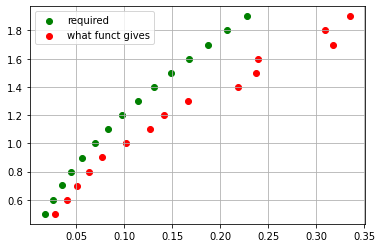

In [103]:
plt.scatter(k[indices1], correct_w_trips[indices1], label = "required", color = "green")
plt.scatter(k_trip, freqs, label = "what funct gives", color = "red")

plt.grid(True)
plt.legend()

In [104]:
kx

array([-0.0126933 ,  0.0126933 ,  0.        ,  0.        ,  0.0126933 ,
       -0.0126933 ,  0.        , -0.02538661, -0.02538661,  0.12693304,
        0.06346652, -0.12693304,  0.08885313, -0.10154643, -0.13962634])

In [105]:
required_k = k[indices1]
required_k

array([0.018 , 0.0255, 0.035 , 0.045 , 0.0565, 0.0695, 0.0835, 0.098 ,
       0.114 , 0.131 , 0.149 , 0.1675, 0.187 , 0.2075, 0.2285])

In [217]:
def plot_triplets_vs_disp_surface(thresh_freq, max_freq, step_size, h, z, U, psi):
    freqs = np.arange(thresh_freq, max_freq, step_size)
    kx_list = []
    ky_list = []

    for f in freqs:
        i = np.argmin(np.abs(spec3d.w[len(t)//2:] - f))
        # Finds the index of the closest value in spec3d.w to f 
        
        spec = spec3d.spectrum()
        spec_values = spec[len(t)//2 + i,:,:]
        # Gives the kx and ky values of corresponding to the frequencie[i]
    
        max_index = np.unravel_index(np.argmax(spec_values), spec_values.shape)
        # Finds the specific index of the maximum value in spec_values
    
        max_kx = spec3d.kx[max_index[0]]
        max_ky = spec3d.ky[max_index[1]]
        # Finds the value of kx and ky corresponding to the maximum spectral density 
        
        kx_list.append(max_kx)
        ky_list.append(max_ky)
    
    fig = plt.figure(figsize=(7,7))
    axes = fig.add_subplot(111, projection='3d')
    plotting_interface.plot_disp_shell(axes, h, z, U, psi)
    
    kx = np.array(kx_list)
    ky = np.array(ky_list)    

    for j in range(0, len(freqs)):
        axes.scatter(kx_list[j], ky_list[j], freqs[j], color='red', s=40)
    
    plt.show()
    
    return kx, ky, freqs

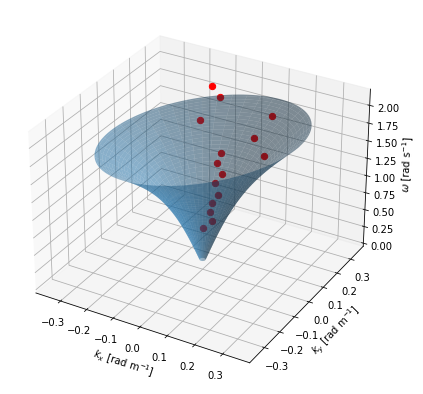

In [235]:
kx, ky, freqs = plot_triplets_vs_disp_surface(thresh_freq = 0.5 , max_freq = 2, step_size = 0.1, h = 10, z=z, U=U , psi = 0)

In [236]:
ky

array([0.02538661, 0.03807991, 0.05077321, 0.06346652, 0.07615982,
       0.10154643, 0.12693304, 0.13962634, 0.16501295, 0.17770625,
       0.22847947, 0.20309286, 0.30463929, 0.29194598, 0.30463929])

In [237]:
k_trip = np.sqrt(kx**2+ky**2)
k_trip

array([0.02838309, 0.04013975, 0.05077321, 0.06346652, 0.07721035,
       0.10233669, 0.12693304, 0.14191545, 0.16695434, 0.21838385,
       0.23713048, 0.23949677, 0.31733259, 0.30910214, 0.33511283])

In [238]:
required_k

array([0.018 , 0.0255, 0.035 , 0.045 , 0.0565, 0.0695, 0.0835, 0.098 ,
       0.114 , 0.131 , 0.149 , 0.1675, 0.187 , 0.2075, 0.2285])

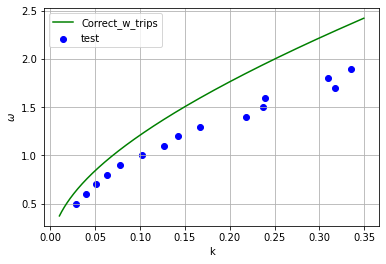

In [214]:
plt.plot(k, correct_w_trips, color = 'green', label = "Correct_w_trips")
#plt.scatter(required_k, freqs, color='red', label="found values")
plt.scatter(k_trip, freqs, color='blue', label="test")

plt.xlabel("k")
plt.ylabel("$\omega$")
plt.grid(True)
plt.legend()

In [239]:
def estimate_U_eff_psi_at_w(w, k_cur, th_cur, h=1000, U0_vec=[0, 0]):
    w0_cur = np.sqrt(9.81*k_cur*np.tanh(k_cur*h))
    def disp_rel(U_vec):
        Ux, Uy = U_vec
        return np.sum(np.abs(w-w0_cur - k_cur*(np.cos(th_cur)*Ux + np.sin(th_cur)*Uy))**2)

    opt = minimize(disp_rel, U0_vec)
    Ux, Uy = opt.x
    U_eff = np.sqrt(Ux**2 + Uy**2)
    psi = np.arctan2(Uy, Ux)
    return U_eff, psi

In [247]:
estimate_U_eff_psi_at_w(freqs, k_trip, k_trip)

(0.5854447297925282, 1.7505671943840844)

In [242]:
k_trip.shape

(15,)